# Stability of Least-Squares Solvers on Vandermonde Systems

This notebook compares three ways to solve noisy polynomial least-squares problems:
normal equations (with LU), QR factorization, and `numpy.linalg.lstsq`. 
For varying polynomial degrees and noise levels, we measure the average relative error 
of each method and examine how conditioning affects stability.


In [2]:
# imports 

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

In [3]:
# degrees of Vandermond matrix

# n_vec = [2**2, 2**3, 2**4, 2**5, 2**6, 2**7] # degrees
n_vec = [4, 6, 8, 10, 12, 14] # degrees

m = 14 # number of data points

z = np.linspace(-1, 1, m) # data points

sigma = [1e-10, 1e-8, 1e-6, 1e-4, 1e-2] # noise levels

n_trial = 10 # number of trials for averaging

In [5]:
np.random.seed(67) # for reproducibility

# Loop over degrees, build Vandermonde matrix, solve for coefficients and report errors 

ne_err = np.zeros((len(n_vec), len(sigma)))
qr_err = np.zeros((len(n_vec), len(sigma)))
lstsq_err = np.zeros((len(n_vec), len(sigma)))

for n in n_vec:
    
    # index of this degree in n_vec (for storing errors)
    n_ind = n_vec.index(n)
    
    # build Vandermonde matrix
    A = np.vander(z, N=n, increasing=True)

    # ground truth solution 
    x = np.ones(n)
    x = x / np.linalg.norm(x)

    # exact right-hand side b = A x
    b = A @ x

    # Experiment 1 (normal equations)
    ATA = A.T @ A                      # A^T A
    P, L, U = sp.linalg.lu(ATA)        # LU factorization of A^T A

    # experiment 2 (QR)
    Q, R = np.linalg.qr(A, mode='reduced')   # A = Q R

    # loop over noise levels sigma
    for s in sigma:
        
        s_ind = sigma.index(s)

        total_ne_err    = 0.0
        total_qr_err    = 0.0
        total_lstsq_err = 0.0

        # repeat experiment n_trial times and average
        for trial in range(n_trial):
            
            # random noise vector w ~ N(0, I_m)
            w = np.random.randn(m)

            # perturbed right-hand side:
            # b_sigma = b + s * (||b||_2 / ||w||_2) * w
            w_norm = np.linalg.norm(w)
            b_norm = np.linalg.norm(b)
            b_sigma = b + s * (b_norm / w_norm) * w

            # ---------- Experiment 1: normal equations via LU ----------
            # solve (A^T A) x = A^T b_sigma
            rhs = A.T @ b_sigma                # right-hand side
            rhs_perm = P.T @ rhs               # L U x = P^T rhs

            # forward solve L y = P^T rhs
            y = sp.linalg.solve_triangular(L, rhs_perm, lower=True)

            # backward solve U x_ne = y
            x_ne = sp.linalg.solve_triangular(U, y, lower=False)

            # ---------- Experiment 2: QR decomposition ----------
            # A = Q R => R x_qr = Q^T b_sigma
            Qt_b = Q.T @ b_sigma
            x_qr = sp.linalg.solve_triangular(R, Qt_b, lower=False)

            # ---------- Experiment 3: numpy lstsq ----------
            x_ls, *_ = np.linalg.lstsq(A, b_sigma, rcond=None)

            # accumulate relative errors for this trial
            denom = np.linalg.norm(x)
            total_ne_err    += np.linalg.norm(x_ne - x) / denom
            total_qr_err    += np.linalg.norm(x_qr - x) / denom
            total_lstsq_err += np.linalg.norm(x_ls - x) / denom

        # store the average relative errors for this (n, sigma)
        ne_err[n_ind, s_ind]    = total_ne_err    / n_trial
        qr_err[n_ind, s_ind]    = total_qr_err    / n_trial
        lstsq_err[n_ind, s_ind] = total_lstsq_err / n_trial


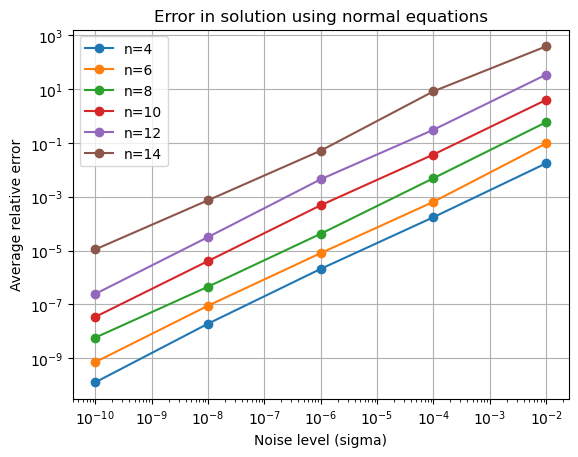

In [6]:
# plot the average relative errors computed using normal equations

for i in enumerate(n_vec):
    plt.loglog(sigma, ne_err[i[0], :], marker='o', label=f'n={i[1]}')
plt.xlabel('Noise level (sigma)')
plt.ylabel('Average relative error')
plt.title('Error in solution using normal equations')
plt.legend()
plt.grid(True)
plt.show()

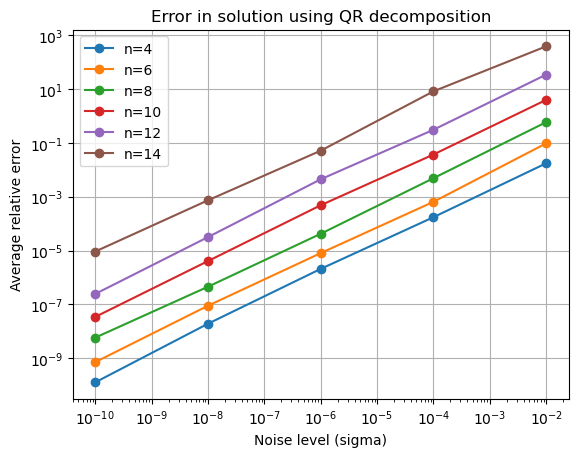

In [7]:
# plot the average relative errors computed using QR decomposition

for i in enumerate(n_vec):
    plt.loglog(sigma, qr_err[i[0], :], marker='o', label=f'n={i[1]}')
plt.xlabel('Noise level (sigma)')
plt.ylabel('Average relative error')
plt.title('Error in solution using QR decomposition')
plt.legend()
plt.grid(True)
plt.show()

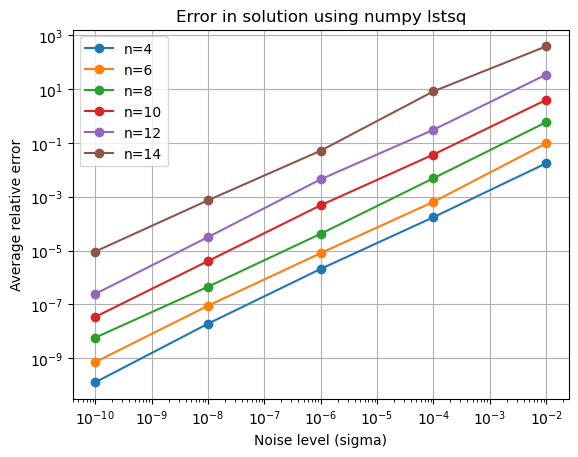

In [8]:
# plot the average relative errors computed using numpy lstsq
for i in enumerate(n_vec):
    plt.loglog(sigma, lstsq_err[i[0], :], marker='o', label=f'n={i[1]}')
plt.xlabel('Noise level (sigma)')
plt.ylabel('Average relative error')
plt.title('Error in solution using numpy lstsq')
plt.legend()
plt.grid(True)

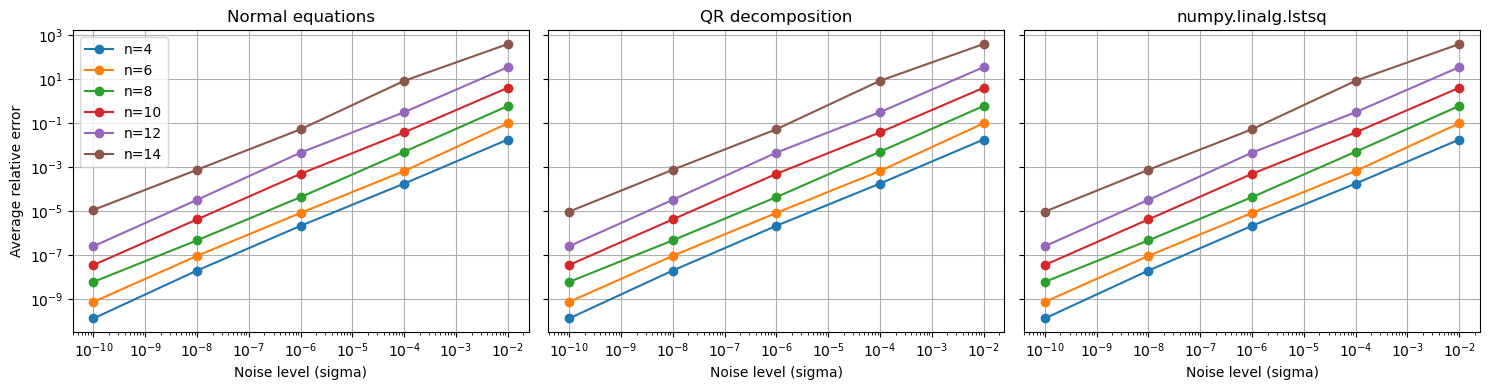

In [9]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharex=True, sharey=True)

# Panel 1: normal equations
for idx, n in enumerate(n_vec):
    axes[0].loglog(sigma, ne_err[idx, :], marker='o', label=f'n={n}')
axes[0].set_title('Normal equations')
axes[0].set_xlabel('Noise level (sigma)')
axes[0].set_ylabel('Average relative error')
axes[0].grid(True)
axes[0].legend()

# Panel 2: QR
for idx, n in enumerate(n_vec):
    axes[1].loglog(sigma, qr_err[idx, :], marker='o', label=f'n={n}')
axes[1].set_title('QR decomposition')
axes[1].set_xlabel('Noise level (sigma)')
axes[1].grid(True)

# Panel 3: lstsq
for idx, n in enumerate(n_vec):
    axes[2].loglog(sigma, lstsq_err[idx, :], marker='o', label=f'n={n}')
axes[2].set_title('numpy.linalg.lstsq')
axes[2].set_xlabel('Noise level (sigma)')
axes[2].grid(True)

plt.tight_layout()

# save to file
fig.savefig('method_comparison_all_n.png', dpi=300, bbox_inches='tight')
plt.show()


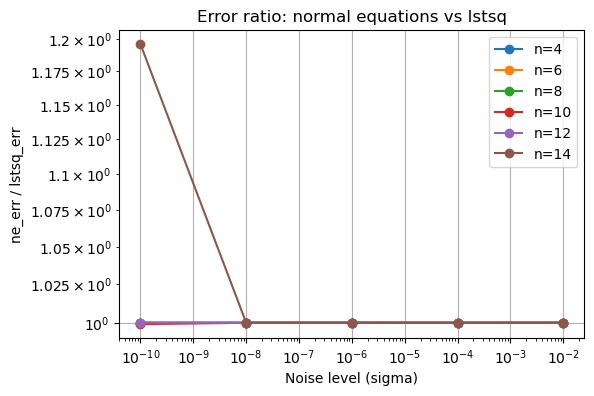

In [10]:
fig, ax = plt.subplots(figsize=(6, 4))

for idx, n in enumerate(n_vec):
    ratio = ne_err[idx, :] / lstsq_err[idx, :]
    ax.loglog(sigma, ratio, marker='o', label=f'n={n}')

ax.set_xlabel('Noise level (sigma)')
ax.set_ylabel('ne_err / lstsq_err')
ax.set_title('Error ratio: normal equations vs lstsq')
ax.grid(True)
ax.legend()

# fig.savefig('ratio_ne_to_lstsq.png', dpi=300, bbox_inches='tight')
plt.show()


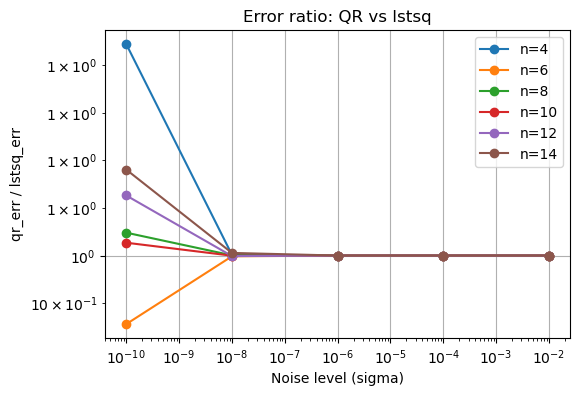

In [11]:
fig, ax = plt.subplots(figsize=(6, 4))

for idx, n in enumerate(n_vec):
    ratio = qr_err[idx, :] / lstsq_err[idx, :]
    ax.loglog(sigma, ratio, marker='o', label=f'n={n}')

ax.set_xlabel('Noise level (sigma)')
ax.set_ylabel('qr_err / lstsq_err')
ax.set_title('Error ratio: QR vs lstsq')
ax.grid(True)
ax.legend()

#fig.savefig('ratio_qr_to_lstsq.png', dpi=300, bbox_inches='tight')
plt.show()


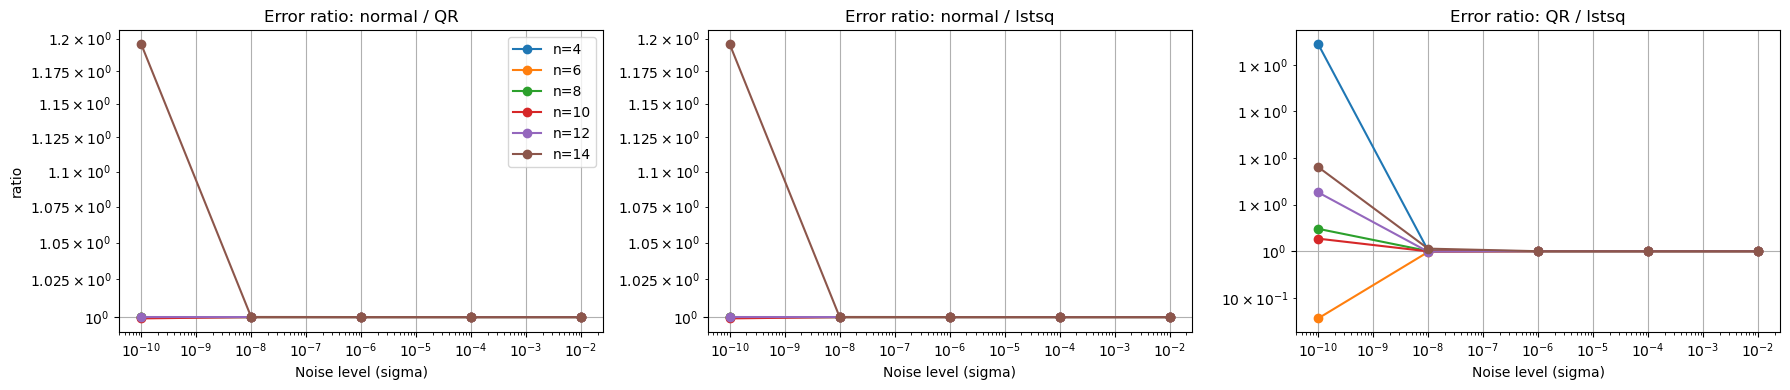

In [16]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 3, figsize=(18, 4), sharex=True)

# --- Panel 1: normal equations / QR ---
for idx, n in enumerate(n_vec):
    ratio_ne_qr = ne_err[idx, :] / qr_err[idx, :]
    axes[0].loglog(sigma, ratio_ne_qr, marker='o', label=f'n={n}')
axes[0].set_title('Error ratio: normal / QR')
axes[0].set_xlabel('Noise level (sigma)')
axes[0].set_ylabel('ratio')
axes[0].grid(True)
axes[0].legend()

# --- Panel 2: normal equations / lstsq ---
for idx, n in enumerate(n_vec):
    ratio_ne_ls = ne_err[idx, :] / lstsq_err[idx, :]
    axes[1].loglog(sigma, ratio_ne_ls, marker='o', label=f'n={n}')
axes[1].set_title('Error ratio: normal / lstsq')
axes[1].set_xlabel('Noise level (sigma)')
axes[1].grid(True)

# --- Panel 3: QR / lstsq ---
for idx, n in enumerate(n_vec):
    ratio_qr_ls = qr_err[idx, :] / lstsq_err[idx, :]
    axes[2].loglog(sigma, ratio_qr_ls, marker='o', label=f'n={n}')
axes[2].set_title('Error ratio: QR / lstsq')
axes[2].set_xlabel('Noise level (sigma)')
axes[2].grid(True)

plt.tight_layout()
fig.savefig('error_ratio_all_methods.png', dpi=300, bbox_inches='tight')
plt.show()


### Discussion

Across all degrees `n` and noise levels, `numpy.linalg.lstsq` is consistently as good as
or better than the normal-equation approach, while QR closely tracks its behavior.
As expected, the error grows with increasing noise and with larger Vandermonde degree.
The final condition number printout confirms that `AᵀA` is dramatically worse conditioned
than `A`, explaining why normal equations are most fragile numerically.


In [18]:
print(np.linalg.cond(A))
print(np.linalg.cond(A.T @ A))

363830.7576924191
132372238579.85995
